In [1]:
import os
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import keras_ocr

C:\Users\benst\AppData\Local\Temp\ipykernel_8724\4080202051.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def get_metadata(ID):
    metadata = pd.read_csv(os.path.join('inputs\metadata', ID +'.csv'))
    return metadata

## get scale
- scale a one pixel width copy of the scale image by the range of efficiencies
- if rgb's span multiple efficiencies (assumtpion they will no be separated by much) then take the mean efficiency over the rgb's

In [3]:
def get_scale(ID, metadata):

    scale_image = Image.open(os.path.join('inputs\scales', ID +'.png'))
    scale = np.array(scale_image)
    scale = scale[:,0,:3]

    su = metadata[metadata['Dim'] == 'SU']['z'].values[0]
    sl = metadata[metadata['Dim'] == 'SL']['z'].values[0]
    scale_range = su - sl

    scale_items = scale.shape[0]
    scale_fidelity = scale_range / scale_items
    z_values = np.arange(1, scale_items + 1) * scale_fidelity
    z_values_df = pd.DataFrame(z_values, columns=['z'])
    scale_df = pd.DataFrame(scale, columns=['r', 'g', 'b'])
    scale_df = scale_df.join(z_values_df)
    scale_df = (scale_df.groupby(['r','g','b']).agg(z_mean=('z', 'mean'))).reset_index()
    scale = scale_df.to_numpy()

    return scale

## get efficiency map

#### infill text
- read cropped efficiency map image 
- use a bounding box ocr to identify text
- inpaint these regions

In [4]:
# infill text using ocr

def infill_text(ID):

    def midpoint(x1, y1, x2, y2):
        x_mid = int((x1 + x2)/2)
        y_mid = int((y1 + y2)/2)
        return (x_mid, y_mid)

    pipeline = keras_ocr.pipeline.Pipeline()

    img = keras_ocr.tools.read(os.path.join('inputs\efficiency_maps', ID +'.png'))

    prediction_groups = pipeline.recognize([img])
    mask = np.zeros(img.shape[:2], dtype="uint8")
    for box in prediction_groups[0]:
        x0, y0 = box[1][0]
        x1, y1 = box[1][1] 
        x2, y2 = box[1][2]
        x3, y3 = box[1][3] 
        
        x_mid0, y_mid0 = midpoint(x1, y1, x2, y2)
        x_mid1, y_mi1 = midpoint(x0, y0, x3, y3)
        
        thickness = int(math.sqrt( (x2 - x1)**2 + (y2 - y1)**2 ))
        
        cv2.line(mask, (x_mid0, y_mid0), (x_mid1, y_mi1), 255,    
        thickness)
        img = cv2.inpaint(img, mask, 7, cv2.INPAINT_NS)
                    
    return(img)

#### infill lines and egdes
- convert image output to grayscale
- Use Canny edge detection to identify edges
- inpaint these extended by a region

In [5]:
def infill_lines(im):

    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

    edges = cv2.Canny(gray, 50, 150)

    # Create a mask by dilating the edges
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.dilate(edges, kernel, iterations=1)

    nolines = cv2.inpaint(im, mask, inpaintRadius=3, flags=cv2.INPAINT_NS)

    return nolines

#### infill black
- convert image to grayscale
- infill black

In [6]:
def infill_no_in_scale(im):

    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

    black = [0,1,2,3,4] # these are black and close to black

    mask = np.ones_like(gray) * 255  # Initialize mask with all white pixels
    for value in black:
        mask[gray == value] = 0  # Set pixels with predefined grayscale values to black in the mask

    noblack = cv2.inpaint(im, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

    return noblack

In [7]:
image = nolines.copy()

NameError: name 'nolines' is not defined

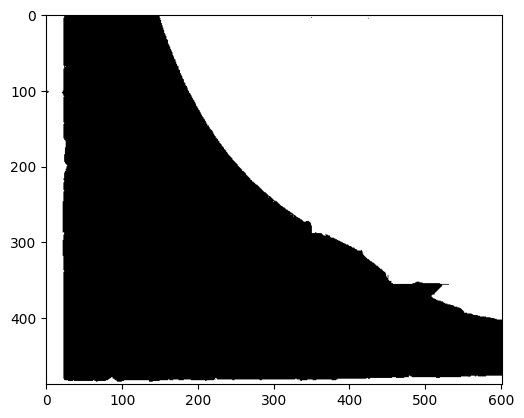

In [10]:
white_threshold = 250

mask = np.ones_like(image[:, :, 0], dtype=np.uint8) * 255
for r in range(image.shape[0]):
    for c in range(image.shape[1]):
        if not any(np.array_equal(image[r, c], scale[:,:3]) for color in scale[:,:3]):
            if np.all(image[r, c] < white_threshold):
                mask[r, c] = 0

plt.imshow(mask)           
                
#inpaint_image = cv2.inpaint(image, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

#plt.imshow(inpaint_image)



In [11]:
inpaint_image = cv2.inpaint(image, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

plt.imshow(inpaint_image)

error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\photo\src\inpaint.cpp:767: error: (-210:Unsupported format or combination of formats) The mask must be 8-bit 1-channel image in function 'icvInpaint'


In [36]:
image[200][300]

array([255, 255, 255], dtype=uint8)

In [8]:
def infill_not_in_scale(im, scale):

    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

    _additional_gs = [250,251,252,253,254,255] # these are black and close to black

    # Define the predefined list of grayscale values
    scale += _additional_gs

    mask = np.ones_like(gray) * 255  # Initialize mask with all white pixels
    for value in scale:
        mask[gray == value] = 0  # Set pixels with predefined grayscale values to black in the mask

    inscale = cv2.inpaint(im, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

    return inscale

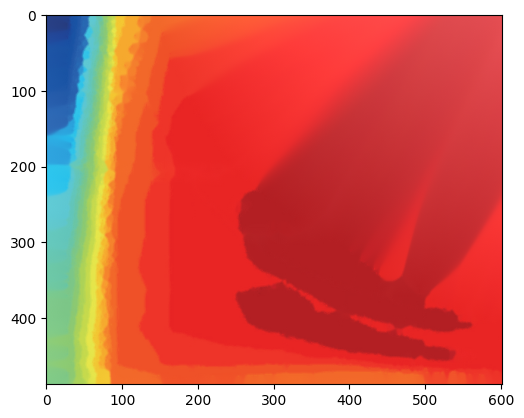

In [115]:
# Create a mask where pixels with predefined RGB values are set to 0 (areas to inpaint)
mask = np.ones_like(image[:, :, 0], dtype=np.uint8) * 255
for color in scale[:,:3]:
    mask[np.all(image == color, axis=-1)] = 0

# Inpaint the image using the mask
inpaint_image = cv2.inpaint(image, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

plt.imshow(inpaint_image)

In [78]:
#scale[:,:3]

## main

In [9]:
ID = 'HDSRM300'
#ID = 'YASA_P400'
#ID = '180-100-009'

Looking for C:\Users\benst\.keras-ocr\craft_mlt_25k.h5

Instructions for updating:
Use `tf.image.resize(...method=ResizeMethod.BILINEAR...)` instead.

Looking for C:\Users\benst\.keras-ocr\crnn_kurapan.h5
1/1 [==============================] - 3s 3s/step


NameError: name 'infill_black' is not defined

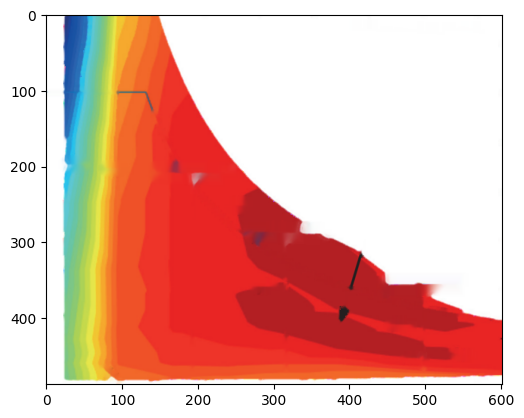

In [10]:
metadata = get_metadata(ID)
scale = get_scale(ID, metadata)
em = infill_text(ID)
plt.imshow(em)
nolines = infill_lines(em)
plt.imshow(nolines)
noblack = infill_black(nolines)
plt.imshow(noblack)

In [122]:
def preprocess(ID):
    metadata = get_metadata(ID)
    scale = get_scale(ID, metadata)
    em = infill_text(ID)
    nolines = infill_lines(em)
    processed_img = infill_black(nolines)

    return processed_img

Looking for C:\Users\benst\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\benst\.keras-ocr\crnn_kurapan.h5
1/1 [==============================] - 4s 4s/step


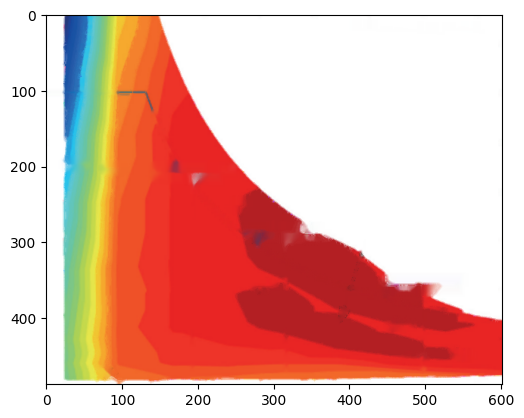

Looking for C:\Users\benst\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\benst\.keras-ocr\crnn_kurapan.h5
1/1 [==============================] - 3s 3s/step


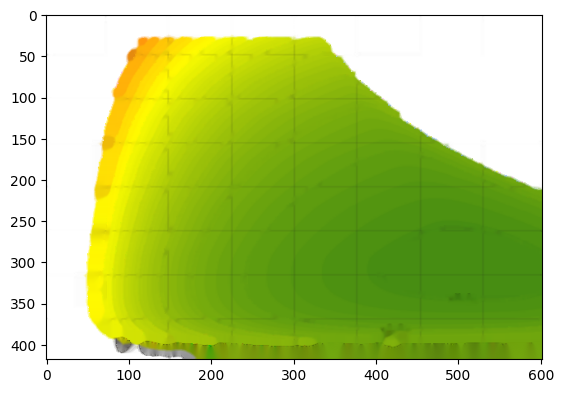

Looking for C:\Users\benst\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\benst\.keras-ocr\crnn_kurapan.h5
1/1 [==============================] - 4s 4s/step


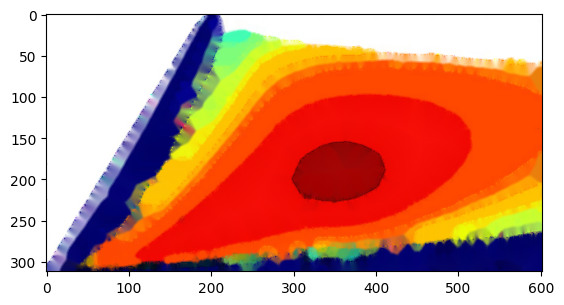

In [124]:
IDS = ['HDSRM300', 'YASA_P400', '180-100-009']
for ID in IDS:
    plt.show()
    processed_img = preprocess(ID)
    plt.imshow(processed_img)

## make efficiency lookup
- map the efficiency map image dimensions to the speed/torque dimensions from metadata
- map rbg's to efficiencies from the scale data
- produce speed, torque, efficiency mapping for pixels that are in the scale and output to csv

In [13]:
def efficiency_lookup(im, scale):
    x_rl = metadata[metadata['Dim'] == 'RL']['x'].values[0]
    x_ll = metadata[metadata['Dim'] == 'LL']['x'].values[0]
    max_xi = im.shape[1] - 1

    y_lu = metadata[metadata['Dim'] == 'LU']['y'].values[0]
    y_ll = metadata[metadata['Dim'] == 'LL']['y'].values[0]
    max_yi = im.shape[0] - 1

    x = []
    y = []
    for xi in range(0, im.shape[1]):
        xbar = ((x_rl - x_ll) * xi) / max_xi
        x.append(xbar)
    for yi in range(0, im.shape[0]):
        ybar = ((y_lu - y_ll) * (max_yi - yi)) / max_yi
        y.append(ybar) 

    X = []
    Y = []
    Z = []

    for xi in range(im.shape[1]):
        for yi in range(im.shape[0]):
            for sc in range(scale.shape[0]):
                if all(im[yi, xi] == scale[sc,:3]):
                    zi = scale[sc,3]
                    X.append(xi)
                    Y.append(yi)
                    Z.append(zi)
                    break
    
    efficiency_lookup_df = pd.DataFrame(zip(X,Y,Z),columns=(['speed','torque','efficiency']))
    efficiency_lookup_df.to_csv('efficiency_lookup_'+ID+'.csv',index=False)

In [14]:
efficiency_lookup(nolines, scale)

In [ ]:
## notes
# make initial cropping etc part of a ui tool
# use cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) to grayscale instead of PIL
# the too black list may need some work, parameters etc, use rgb here now
# test out a gaussian convolution prior to edge detection
# infilling near bounding region is spurrious
# assume vertical scale bar (add option to rotate)
# better ranges
# rewrite to remove for loops, add vectorisation
# infill vs. mask throughout and not output

In [ ]:
"""
def get_scale(ID):

    scale_image = Image.open(os.path.join('inputs\scales', ID +'.png'))
    gs_scale_image = scale_image.convert("L")
    grayscale_array = np.array(gs_scale_image)


    array = np.array([x[0] for x in grayscale_array])
    seen = set()
    scale = []
    for i in array:
        if i not in seen:
            seen.add(i)
            scale.append(i)

    return scale

    def infill_not_in_scale(im, scale):

    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

    _additional_gs = [250,251,252,253,254,255] # these are black and close to black

    # Define the predefined list of grayscale values
    scale += _additional_gs

    mask = np.ones_like(gray) * 255  # Initialize mask with all white pixels
    for value in scale:
        mask[gray == value] = 0  # Set pixels with predefined grayscale values to black in the mask

    inscale = cv2.inpaint(im, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

    return inscale

    def infill_no_in_scale(im):

    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

    black = [0,1,2,3,4] # these are black and close to black

    mask = np.ones_like(gray) * 255  # Initialize mask with all white pixels
    for value in black:
        mask[gray == value] = 0  # Set pixels with predefined grayscale values to black in the mask

    noblack = cv2.inpaint(im, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

    return noblack
"""